# DayTrader Quickstart
Welcome!  By the end of this quickstart, you should be up and running, training your own models to trade in the stock market.  To do this, we will
1. Make available the files we will train on
2. Split and normalize the data into training and testing sets
3. Train
4. Evaluate

## Part 1: Accessing the Files
To get started, go to [this link](https://drive.google.com/drive/folders/1_Yz8-ZyOjmCRRXeCSrmUVFpn0mfxneUf?usp=sharing), right click on the `daytrader` folder button, and click `Add to My Drive`.  When you've done that, we will log into your google drive to access the files.  

Note: logging in will give this program **write** access to your google drive.  The only writing this program will be doing is to create a folder called `daytrader_checkpts` where training checkpoints and saved models will be stored.  After running the next two cells, all the code for this quickstart will be contained within your "Files" directory (on the left hand side of the screen) in `data_loader.py`, `model.py`, and `utils.py` if you want to double check for yourself. 

As a broad note - sometimes Google Drive times out, so you may have to stop and rerun a cell now and again if you don't see a loading bar after a 15 or 20 seconds.

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
# copy python files into local dir
from shutil import copyfile
base_path = '/content/drive/My Drive/daytrader/'
files = ['data_loader.py', 'model_file.py', 'utils.py']
for file_name in files:
  copyfile(f'{base_path}{file_name}', f'./{file_name}')

# import files
%tensorflow_version 2.x
from data_loader import *
from model_file import *
from utils import *

# initialize path locations
periods = [4, 5, 6, 8, 12, 14, 20, 50]
prices_path = f'{base_path}huge_stock_csvs/'
indicators_path = get_indicators_path(base_path, periods)
checkpts_path = f'/content/drive/My Drive/daytrader_checkpts/checkpts/'
models_path = f'/content/drive/My Drive/daytrader_checkpts/models/'

## Part 2: Wrangling the Data
Now, let's take a look at the indicators themselves.  Each row contains a date, some standard information about the stock at that date (open, high, low, close, and volume) and [indicators](https://www.investopedia.com/terms/t/technicalindicator.asp) calculated at that date for each period in `periods`, listed above.

For example, [sma_4](https://www.alphavantage.co/documentation/#sma), is a "simple moving average" calculated over the last four periods.  For some time t, this corresponds to `mean(close[t-3], close[t-2], close[t-1], close[t])`.

If you think this looks intimidating, and like way more data than we need, you're right!  You'll probably only be using subsets of this data in training your models - we'll get to that in a few cells.

In [0]:
sym_subset=['TSLA', 'AMZN', 'AAPL'] # sym_subset defaults to [], which pulls all symbols from prices_path - this can be very computationally expensive
dfs = load_indicators(indicators_path, periods, sym_subset=sym_subset, predict_today=False)
dfs[0].head(3)


Loading indicator dataframes...
3/3 [==============================] - 13s 4s/step


,date,open,high,low,close,volume,sma_4,ema_4,wma_4,bbands_high_4,bbands_low_4,per_b_high_4,per_b_low_4,trima_4,rsi_4,willr_4,atr_4,plus_di_4,minus_di_4,dx_4,adx_4,roc_4,macd_4,macd_histogram_4,cci_4,aroon_osc_4,chaikin_osc_4,chaikin_mf_4,stoch_per_k_4,stoch_per_d_4,sma_5,ema_5,wma_5,bbands_high_5,bbands_low_5,per_b_high_5,per_b_low_5,trima_5,rsi_5,willr_5,...,macd_histogram_20,cci_20,aroon_osc_20,chaikin_osc_20,chaikin_mf_20,stoch_per_k_20,stoch_per_d_20,sma_50,ema_50,wma_50,bbands_high_50,bbands_low_50,per_b_high_50,per_b_low_50,trima_50,rsi_50,willr_50,atr_50,plus_di_50,minus_di_50,dx_50,adx_50,roc_50,macd_50,macd_histogram_50,cci_50,aroon_osc_50,chaikin_osc_50,chaikin_mf_50,stoch_per_k_50,stoch_per_d_50,trange,obv,adl,ichi_dist_day,ichi_dist_week,ichi_dist_month,label,weight,return
51,2010-09-09,21.00,21.05,20.69,20.71,376197,20.799999,20.720529,20.767,21.184966,20.415033,2.467574,1.532426,20.773333,56.577048,66.666916,0.584196,27.100794,8.015132,54.350443,50.309800,-1.661920,0.833370,-0.067050,-17.338960,-50.0,128635.751447,-0.179656,26.249911,47.046695,20.852001,20.677071,20.795333,21.254274,20.449729,2.705999,1.294001,20.810000,58.353268,67.307953,...,-0.439762,-17.338960,75.0,127797.953913,0.160173,84.910481,85.081005,19.770000,0.676517,19.875255,22.806288,16.733713,1.380824,2.619176,19.807739,54.511532,38.854308,1.504048,0.132972,0.000000,100.000000,0.000000,-13.311010,3.080682,2.825024,-17.338960,-10.0,-20005.390302,-0.001295,37.111395,24.817788,0.359999,-5099345.0,-229861.195929,10.402498,20.709999,20.709999,0.0,0.026074,0.973926
52,2010-09-10,20.75,20.93,19.76,20.17,385689,20.580000,20.500318,20.515,21.117587,20.042413,3.525335,0.474665,20.655000,37.615057,100.000000,0.730647,16.251527,36.627560,38.533254,47.365663,-4.180519,0.760436,-0.111987,-152.387972,-100.0,29549.243533,-0.346468,31.782958,39.209619,20.674000,20.508048,20.568000,21.284389,20.063610,3.651404,0.348596,20.713333,42.931217,100.000000,...,-0.472667,-152.387972,75.0,28863.772819,0.165866,68.956062,81.212125,19.696800,1.440967,19.890941,22.506021,16.887580,1.663109,2.336891,19.793677,53.775395,29.058431,1.497367,0.130894,1.242181,80.934121,50.000000,-15.358791,4.047398,3.033392,-152.387972,-8.0,-89893.801938,-0.002960,47.440588,40.964650,1.170000,-5485034.0,-345238.367804,0.000000,20.170000,20.170000,1.0,0.027268,1.027268
53,2010-09-13,20.89,20.90,20.50,20.72,360703,20.625000,20.588190,20.571,21.171717,20.078283,1.652473,2.347527,20.563333,57.128076,24.657592,0.730485,12.191346,27.476756,38.533254,45.157561,0.876331,0.738503,-0.107136,20.166282,-50.0,-2195.800487,-0.147220,74.418591,44.150487,20.608000,20.578698,20.583333,21.101704,20.114296,1.546289,2.453711,20.614444,57.299108,24.657592,...,-0.454485,20.166282,70.0,-2756.640165,0.129575,80.921049,78.262531,19.671999,2.197007,19.931067,22.422135,16.921863,1.237856,2.762144,19.786554,54.415179,20.000022,1.482020,0.129605,1.229943,80.934121,60.311374,-5.646629,4.802547,3.030833,20.166282,-6.0,-98835.711528,-0.002788,70.689645,51.747209,0.730000,-5124331.0,-309168.926398,0.325000,20.719999,20.719999,1.0,0.019305,1.019305


### The Indicators Dataframe

The full list of indicators available to you is:

```
['sma', 'ema', 'wma', 'bbands_high', 'bbands_low', 'per_b_high', 'per_b_low', 'trima', 'rsi', 'willr', 'atr', 'trange', 'plus_di', 'minus_di', 'dx', 'adx', 'roc', 'macd',  'macd_histogram', 'cci', 'aroon_osc', 'adl', 'chaikin_osc', 'chaikin_mf', 'obv', 'stoch_per_k', 'stoch_per_d', 'ichi_dist_day', 'ichi_dist_week', 'ichi_dist_month', 'label', 'weight', 'return']
```

Most of these are detailed extensively online.  The only ones worth explaning are:
* `per_b_{high|low}`: how far away the price is from the {high | low} [bollinger bands](https://www.investopedia.com/terms/b/bollingerbands.asp) line (divided by the standard deviation of the price over the last `period` days). This is useful because some traders sell when a price is close to the high band and buy when it is close to the low band.
* `ichi_dist_{day|week|month}`: this calculates the [ichimoku cloud](https://www.investopedia.com/terms/i/ichimoku-cloud.asp), and returns the distance of the price from the cloud, calculated at different intervals (day | week | month).  Distance is 0 if the price is inside the cloud, positive if above, negative if below.

Other important columns we'll make use of are:
* `return`: if you bought a stock at time `t`, and sold it the next day at time `t+1`, what multiplier would your money be worth? Would you have made `1.2x` your money? `.9x` your money?
* `label`: was the right move to buy or sell?  buy => 1, sell => 0. i.e. was `return` > 1?
* `weight`: what percent on how money would you have made / lost if you bought? `weight = abs(return - 1))`. We will use this to weight our training process, so we penalize mistakes more or less depending on how much the stock moved after we bought/sold.  We do not currently support selling short or options, so the loss from selling when a stock goes up can be thought of as opportunity cost.

### Splitting into Train/Test

#### The Problem with Splitting on Stocks
In non-ML based approaches, "backtesting an algorithm" is simple.  You write the algorithm, run it on the past, and see how well it did. Using ML models, the notion of "backtesting" must become more flexible, because we do not want to test our models on data it has trained with for fear of poor future generalization.

For example, if we trained on the entire history of the stocks `['AAPL', 'AMZN']` and tested on `['TSLA']`, we might be "cheating" ourselves, because when we get to the 2008 crash, we might have learned to detect it from `AAPL` and `AMZN`'s experiences in that time. Our algorithm might perform well on `TSLA`, but its evaluation would be inflated.  Because of this, splitting the data along different stocks can damage the integrity of the training/testing process.

\

#### Window Splitting
Instead, we split on "windows". You specify a start date for the testing window (or it will be chosen randomly), and a ratio (what proportion of the points should be training) and the algorithm will iterate through the dates until it has captured 20% of the total datapoints in the testing set. 
![alt text](https://drive.google.com/uc?export=view&id=1S7L9KK0MUHVPk4kTNZZO0iYr4SXmPfBO)
A quick note: this may not be exactly 20% of the total time because stocks have different start and end points.  In the examples below, the training times may span much more than 80% because AAPL has a much longer history than TSLA, so if the testing times are concentrated in the period where all three stocks have datapoints, it will take fewer dates for it to reach 20% of the total datapoints.

In [0]:
df_train, df_test = split_dfs(dfs, start_date='1999-01-01', ratio=.8, quiet=False, concat=True) # concat = True returns a single df_train with all rows concatenated

Backtesting from 1999-01-01 to 2004-12-08


In [0]:
# normalize the training set, use those params (mean and std for each column) to normalize df_test
norm_params = normalize_df(df_train)
normalize_dfs(df_test, norm_params)

In [0]:
# weight mistakes differently for selling when you should have bought vs buying when you should have sold
# bullish_scalar > 1 punishes mistakes that arise from not buying when you should have more heavily
bullish_scalar = 1
apply_scalars(bullish_scalar, dfs)

## Part 3: Learning
### Learning Setup
Before we dive into creating our model, we need to know how we're going to evaluate it, both in the training portion and afterwards, so we can help it learn from mistakes and get an honest sense of how well it would perform in the wild.

Here, we treat the problem as a classification problem, with the network outputting a probability distribution over how likely it thinks a given datapoint is to lead to buy (1) or sell (0).  We calculate loss using [cross entropy loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) weighted by how much would have been gained, lost, or failed to have been gained on this trade (the `weight` column discussed above).  

To process this learning, we staple the rows of df_train together and the rows of df_test together, completely losing track of which stock was which within our training and testing sets.  This raises an interesting question: how well would our algorithm have performed on the testing set if we had actually traded with it?  For that, we need to define how our algorithm will work.

### The Trading Algorithm
The algorithm, detailed in `model_file/predictions`, and used in the `performance` graph below works in three simple steps:
1. **Turn datapoints into buy confidences**.  At timestep t, look at all stocks that have a datapoint there, (e.g. TSLA does not have a datapoint at 1984-12-04).  Run those datapoints through the model to get confidences in how much the model thinks we should buy this stock.  If `t` was a point where all three stocks had datapoints, we might end up with something like: \
[TSLA, AMZN, AAPL ] \
[.4,    .6,   .7 ] \
2. **Eliminate all buy confidences below a `threshold`**.  Looking at the above example, TSLA's buy confidence isn't very high, so we might say that we'd prefer it not to be considered at all.  This becomes particularly relevant if < k of the stocks have reasonable confidences.  Otherwise we would distribute money to stocks we had low confidence in. If we set `threshold=.5`, this becomes: \
[TSLA, AMZN, AAPL ] \
[0,    .6,   .7 ] \
3. **Distribute money based on the confidences of the top `k` stocks**. Now to distribute money, we simply take the top `k` remaining stocks (in this case, let's assume `k=2`, so we take both stocks), and weight the amount of money we give to each based on our buy confidences - e.g. AMZN would become .6/(.6+.7). When we evaluate, we will weight the return based on these weightings.\
[TSLA, AMZN, AAPL ] \
[0,    .46,   .54 ] \

This should return a number representing the average annual percent gain or loss of the strategy, assuming we reinvest our winnings.  For example, if our strategy earned 10% over 2 years and we reinvested winnings, we would have the equation `1 * x**2 = 1.10` ==> `x = 1.048` ==> 4.8% return per year.

### Selecting the Features
We use [regex](https://www.rexegg.com/regex-quickstart.html) to select the features (columns) from our dataframes to use in training and testing. For example, if we just wanted to use rsi values as an input, we could do that with the following regex and display the outputting dataframe:

In [0]:
df_train.filter(regex='^rsi').head(3)

,rsi_12,rsi_14,rsi_20,rsi_4,rsi_5,rsi_50,rsi_6,rsi_8
date,,,,,,,,
2010-09-09,0.208630,0.183025,0.165628,0.108506,0.208039,0.143491,0.258584,0.276159
2010-09-10,-0.169708,-0.138835,-0.053982,-0.729598,-0.547691,0.041188,-0.420482,-0.275104
2010-09-13,0.155405,0.139368,0.135451,0.132861,0.156382,0.130100,0.178835,0.193501


### Training

Create parameters for training process.

In [0]:
k = 3
threshold= .5
num_epochs = 11
batch_size = 32

regex = '^(rsi|ad|p_vol|per_b)'
input_shape = len(df_train.filter(regex=regex).columns)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='elu', input_shape=(input_shape,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

Saving epoch checkpoints to /content/drive/My Drive/daytrader_checkpts/checkpts/
Epoch	Train Loss	Train Accuracy	Test Loss	Test Accuracy	Perf Result	ETA (mins)
0/11	0.014		52.098%		0.022		48.189%		9.41		0.00
5/11	0.014		53.002%		0.022		51.053%		19.94		0.58
10/11	0.014		53.040%		0.022		51.889%		11.29		0.17


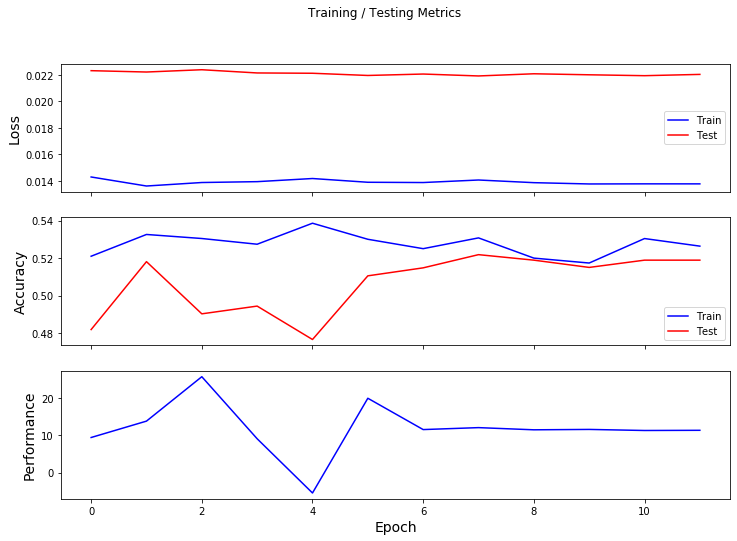

In [0]:
train(model, df_train, df_test, regex, checkpts_path, num_epochs=num_epochs, plot=True, batch_size=batch_size, k=k, threshold=threshold)

The results above will be noisy due to the low number of epochs and small amount of data in this quickstart and unrealistically high because of the success of the stocks (even though this testing period spans the dot-com bubble).

### Saving, Loading, and Evaluating
Now that we have trained our model, we may want to load the model from a specific epoch and see its model performance with different values of k.

In [0]:
epoch = 5
k = 2
m = load_model(checkpts_path, epoch)
model_perf(df_test, m, regex, k=k, threshold=threshold)

Loading model from /content/drive/My Drive/daytrader_checkpts/checkpts//5.h5


19.939114380300115

Or respond to the cranky relative in all of us who asks "yeah, but what if you just bought and held it over the same period?"

In [0]:
model_perf(df_test, m, regex, k=k, threshold=threshold, just_buy=True)

11.462589641301623

Or even "but what if you just bought and held the S&P 500 and held that over the same period?"

In [0]:
sp_perf(df_test, prices_path)

Loading GSPC dataframe


-0.63

Or even better, the difference between your model's performance and the s&p's performance over the same period.

In [0]:
model_perf(df_test, m, regex, k=k, threshold=threshold, minus_sp=True, prices_path=prices_path)

20.57

We may want to save the model.

In [0]:
model_filename = save_model(m, models_path, name=None) # if name==None, will name it one higher than the number of models in the dir

Saved model to /content/drive/My Drive/daytrader_checkpts/models//7.h5


And reload it.

In [0]:
m = load_model(model_filename, None) # if pass in None as model name, will assume path given is a full filename

Loading model from /content/drive/My Drive/daytrader_checkpts/models//7.h5


### Predicting Today
Once you've finished backtesting, you'll probably want to test the algorithm out on day to day trading.  Due to legal restrictions, we use the ["Huge Stock Market Dataset"](https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/) here instead of scraped data.  Using this dataset, we can get the predictions for "today" (in 2017) from the dataset.

In [0]:
preds = get_today_preds(model, indicators_path, periods, sym_subset, norm_params, regex, k, threshold, bullish_scalar)
[elt for elt in preds]


Loading indicator dataframes...
3/3 [==============================] - 0s 126ms/step


Predictions for 2017-11-10
---------------------------
Stock	Proportion of Funds
TSLA	0.0
AMZN	0.493
AAPL	0.507


[('TSLA', 0.0), ('AMZN', 0.49274373932807514), ('AAPL', 0.5072562606719249)]

### Updating your Indicators and Prices
Unfortunately, most sites and APIs that give daily price data have "do not redistribute" clauses that prevent us from sharing the most up to date prices or even code to scrape them with you.  But if you can find a way to download or scrape the most up to date prices yourself, you can make use of the function (reproduced below, but included in `data_loader.py` and available to call here) to update your prices and indicators.  You may need to create a copy of the `daytrader` folder, which you will access as read-only.

 

**def update(new_prices_path, old_prices_path, indicators_path, periods, sym_subset=[], col_mapping=None, download_prices=None)**

Inputs:
* `new_prices_path`: where the new prices are stored.  You can store full price files here or just partials (with newer dates only, for example)
* `old_prices_path`: this will be overwritten with the updated prices from `new_prices_path`
* `indicators_path`
* `periods`: unless you have calculated your own indicators folder, this will be as it was above
* `sym_subset`
* `col_mapping`: the prices files you reference in `new_prices_path` must have columns `[date,open,high,low,close,volume]`.  If those columns are named differently in the files you've downloaded, use `col_mapping` to map from the name you have to the corresponding name.  e.g. if everything else is the same, but your `date` column is named `Times`, pass in `col_mapping={'Times': 'date'}`

Effects:
* modifies `old_prices` to be updated from `new_prices`
* updates all of `sym_subset` in `indicators_path` (this may take a while)
* returns updated `dfs`


In [0]:
# def update(new_prices_path, old_prices_path, indicators_path, periods, sym_subset=[], col_mapping=None, download_prices=None):
#     ''' Update, return all indicators'''
#     remove_icon_files(old_prices_path)
#     sym_subset = update_sym_subset(old_prices_path, sym_subset)
#     if download_prices is not None:
#         download_prices(new_prices_path, old_prices_path, sym_subset=sym_subset)
#     update_prices(new_prices_path, old_prices_path, sym_subset=sym_subset, col_mapping=col_mapping)
#     update_indicators(old_prices_path, indicators_path, periods, sym_subset=sym_subset, first_write=False)
#     dfs = load_indicators(indicators_path, periods, sym_subset=sym_subset)
#     for df in dfs:
#         assert len(check_for_nans(df)) == 0, 'There is a nan in one of your dataframes.  Something went wrong with the update.'
#     return dfs